original: https://www.guruguru.science/competitions/25/discussions/8b97734b-1f76-4075-b1af-5d227d6b70e8/ (@yururoi)


In [1]:
!rm -r /kaggle/working/*
%cd /kaggle/working

/kaggle/working


In [2]:
import os
import sys

PACKAGE_DIR = "/kaggle/src"
sys.path.append(PACKAGE_DIR)
sys.path.append(os.path.join(PACKAGE_DIR, "Penguin-ML-Library"))

In [3]:
import yaml
from penguinml.utils.logger import get_logger, init_logger
from penguinml.utils.set_seed import seed_base

MODEL_NAME = "lightgbm"
CFG = yaml.safe_load(open(os.path.join(PACKAGE_DIR, "config.yaml"), "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])
CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

init_logger(f"{ CFG[MODEL_NAME]['execution']['exp_id']}.log")
logger = get_logger("main")
seed_base(CFG[MODEL_NAME]["execution"]["seed"])

2024-11-21 14:36:49.960723: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 14:36:49.994592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


exp_021


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
set seed: 46


In [4]:
import glob
import os
import pickle
import warnings
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm


In [5]:
class Config:
    N_FOLD = 5
    RANDOM_SATE = 42


NB = "exp1015"

In [6]:
ROOT_DIR = Path("/kaggle")
DATA_DIR = ROOT_DIR / Path("input/atmaCup#18_dataset")

In [7]:
train_df = pl.read_csv(DATA_DIR / "train_features.csv")
test_df = pl.read_csv(DATA_DIR / "test_features.csv")

## 特徴量生成


In [8]:
# train_df と test_dfを結合（特徴量エンジニアリングをしやすくするため）
_all_df = pl.concat([train_df, test_df], how="diagonal")

In [9]:
agg_cols = [
    "vEgo",
    "aEgo",
    "steeringAngleDeg",
    "steeringTorque",
    "gas",
]  # 同一シーンから集計する値のカラム名

# 同一シーンから特徴量作成
exprs = []
exprs += [
    pl.col(agg_col).shift(-1).over("scene").alias(f"{agg_col}_shift-1") for agg_col in agg_cols
]  # 1ステップ前の時間の値
exprs += [
    pl.col(agg_col).shift(1).over("scene").alias(f"{agg_col}_shift1") for agg_col in agg_cols
]  # 1ステップ後の時間の値
exprs += [
    pl.col(agg_col).diff(-1).over("scene").alias(f"{agg_col}_diff-1") for agg_col in agg_cols
]  # 1ステップ前の時間の値との差分
exprs += [
    pl.col(agg_col).diff(1).over("scene").alias(f"{agg_col}_diff1") for agg_col in agg_cols
]  # 1ステップ後の時間の値との差分
exprs += [pl.col(agg_col).mean().over("scene").alias(f"{agg_col}_mean") for agg_col in agg_cols]  # 同一シーンの平均値
exprs += [pl.col(agg_col).std().over("scene").alias(f"{agg_col}_std") for agg_col in agg_cols]  # 同一シーンの標準偏差
exprs += [pl.col(agg_col).max().over("scene").alias(f"{agg_col}_max") for agg_col in agg_cols]  # 同一シーンの最大値
exprs += [pl.col(agg_col).min().over("scene").alias(f"{agg_col}_min") for agg_col in agg_cols]  # 同一シーンの最小値

_all_df = (
    _all_df.with_columns(
        # ID からシーンとデシ秒を作成
        pl.col("ID").str.split("_").list.get(0).alias("scene"),
        pl.col("ID").str.split("_").list.get(1).cast(pl.Int32).alias("decisecond"),
    )
    .sort(
        # shiftと diffが時系列順に並んでいる必要があるためシーンごとに時間軸でソート
        "scene",
        "decisecond",
    )
    .with_columns(exprs)
)

In [10]:
train_folds = pl.read_csv(CFG["dataset"]["train_fold_path"]).rename({"sceneID": "scene"})
_all_df = _all_df.join(train_folds, how="left", on="scene")
# assert train_df["fold"].null_count() == 0

In [11]:
# YOLOの検出結果
import json

yolo_paths = glob.glob("/kaggle/input/yolo-det/det/*.json")
yolo_dfs = []
for path in tqdm(yolo_paths):
    ID = os.path.basename(path).split(".")[0]
    with open(path, "r") as f:
        data = json.load(f)

    yolo_feature = {
        "ID": ID,
        "num_objects": len(data),
    }
    for bbox in data:
        if bbox["x1"] == bbox["x2"] or bbox["y1"] == bbox["y2"]:
            continue

        if bbox["cls"] != "car":
            continue

        # count
        if bbox["cls"] not in yolo_feature:
            yolo_feature[bbox["cls"]] = 0
        yolo_feature[bbox["cls"]] += 1

        # 最も横方向が中央にあるものの情報
        if f"center_x_{bbox['cls']}" not in yolo_feature:
            yolo_feature[f"center_x_{bbox['cls']}"] = -1
        current_dist = abs(yolo_feature[f"center_x_{bbox['cls']}"] - 64)
        now_center_x = (bbox["x1"] + bbox["x2"]) / 2
        now_dist = abs(now_center_x - 64)
        if now_dist < current_dist:
            yolo_feature[f"center_x_{bbox['cls']}"] = now_center_x
            yolo_feature[f"center_y_{bbox['cls']}"] = (bbox["y1"] + bbox["y2"]) / 2
            yolo_feature[f"width_{bbox['cls']}"] = bbox["x2"] - bbox["x1"]
            yolo_feature[f"height_{bbox['cls']}"] = bbox["y2"] - bbox["y1"]
            yolo_feature[f"bottom_{bbox['cls']}"] = bbox["y2"]
            yolo_feature[f"area_{bbox['cls']}"] = (bbox["x2"] - bbox["x1"]) * (bbox["y2"] - bbox["y1"])
            yolo_feature[f"aspect_ratio_{bbox['cls']}"] = (bbox["x2"] - bbox["x1"]) / (bbox["y2"] - bbox["y1"])
            yolo_feature[f"conf_{bbox['cls']}"] = bbox["conf"]
    yolo_dfs.append(yolo_feature)
yolo_df = pl.DataFrame(yolo_dfs)

_all_df = _all_df.join(yolo_df, how="left", on="ID")

100%|██████████| 45098/45098 [00:00<00:00, 75242.40it/s]


In [12]:
# depth
import cv2

depth_features = []
for ID in tqdm(_all_df["ID"]):
    path = f"/kaggle/input/depth_image/depth/{ID}/0.png"
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    patch_size = 16
    this_features = {"ID": ID}
    for i in range(0, 128, patch_size):
        for j in range(0, 64, patch_size):
            patch = image[i : i + patch_size, j : j + patch_size]
            this_features[f"patch_{i}_{j}_mean"] = np.mean(patch)
            this_features[f"patch_{i}_{j}_median"] = np.median(patch)
    depth_features.append(this_features)
depth_df = pl.DataFrame(depth_features)
_all_df = _all_df.join(depth_df, how="left", on="ID")

  0%|          | 0/45098 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 45098/45098 [00:18<00:00, 2387.85it/s]


## feature and target


In [13]:
targets = [
    "x_0",
    "y_0",
    "z_0",
    "x_1",
    "y_1",
    "z_1",
    "x_2",
    "y_2",
    "z_2",
    "x_3",
    "y_3",
    "z_3",
    "x_4",
    "y_4",
    "z_4",
    "x_5",
    "y_5",
    "z_5",
]

# 使う特徴量を指定するより使わない特徴量を指定するほうが試行錯誤が楽
del_columns = targets + ["ID", "scene", "gearShifter", "fold"]

features = list(set(_all_df.columns) - set(del_columns))
features.sort()

print(features)

['aEgo', 'aEgo_diff-1', 'aEgo_diff1', 'aEgo_max', 'aEgo_mean', 'aEgo_min', 'aEgo_shift-1', 'aEgo_shift1', 'aEgo_std', 'area_car', 'aspect_ratio_car', 'bottom_car', 'brake', 'brakePressed', 'car', 'center_x_car', 'center_y_car', 'conf_car', 'decisecond', 'gas', 'gasPressed', 'gas_diff-1', 'gas_diff1', 'gas_max', 'gas_mean', 'gas_min', 'gas_shift-1', 'gas_shift1', 'gas_std', 'height_car', 'leftBlinker', 'num_objects', 'patch_0_0_mean', 'patch_0_0_median', 'patch_0_16_mean', 'patch_0_16_median', 'patch_0_32_mean', 'patch_0_32_median', 'patch_0_48_mean', 'patch_0_48_median', 'patch_112_0_mean', 'patch_112_0_median', 'patch_112_16_mean', 'patch_112_16_median', 'patch_112_32_mean', 'patch_112_32_median', 'patch_112_48_mean', 'patch_112_48_median', 'patch_16_0_mean', 'patch_16_0_median', 'patch_16_16_mean', 'patch_16_16_median', 'patch_16_32_mean', 'patch_16_32_median', 'patch_16_48_mean', 'patch_16_48_median', 'patch_32_0_mean', 'patch_32_0_median', 'patch_32_16_mean', 'patch_32_16_median', 

In [14]:
# MAEを計算
def evaluation(true_values, pred_values):
    abs_diff = abs(true_values - pred_values)
    mae = np.mean(
        abs_diff.reshape(
            -1,
        )
    )
    return mae

### encoding


In [15]:
# label encdoding
categorical_columns = ["gearShifter"]

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    _all_df = _all_df.with_columns(pl.Series(le.fit_transform(_all_df[col])).alias(f"{col}_le"))
cate_features = [f"{col}_le" for c in categorical_columns]
features = list(set(features) | set(cate_features))

# count encoding
count_enc = ["gearShifter"]
_all_df = _all_df.with_columns([pl.col(c).count().over(c).alias(f"{c}_count") for c in count_enc])
count_features = [f"{c}_count" for c in count_enc]
features = list(set(features) | set(count_features))


train_df = train_df.join(_all_df, how="left", on="ID")
test_df = test_df.join(_all_df, how="left", on="ID")

In [16]:
# melt
train_dfs = []
test_dfs = []
for i, target in enumerate(targets):
    this_train_df = train_df.clone()
    this_train_df = (
        this_train_df.with_columns(
            pl.lit(1.0).alias(f"target_is_{target}"),
            pl.lit(target).alias("target_name"),
        )
        .rename({target: "target"})
        .drop(set(targets) - {target})
    )

    this_test_df = test_df.clone()
    this_test_df = (
        this_test_df.with_columns(
            pl.lit(1.0).alias(f"target_is_{target}"),
            pl.lit(target).alias("target_name"),
        )
        .rename({target: "target"})
        .drop(set(targets) - {target})
    )

    train_dfs.append(this_train_df)
    test_dfs.append(this_test_df)
    features = list(set(features) | {f"target_is_{target}"})

train_lgbm_df = pl.concat(train_dfs, how="diagonal")
test_lgbm_df = pl.concat(test_dfs, how="diagonal")

In [17]:
def train_lgbm(target):
    params = {
        "boosting_type": "gbdt",
        "metric": "mae",  # 今回の評価指標がMAEを使用
        "objective": "regression",
        "n_jobs": -1,
        "seed": Config.RANDOM_SATE,
        "learning_rate": 0.01,
        # "device": "gpu"
        "verbosity": -1,
    }

    oof_pred = np.zeros(len(train_lgbm_df))
    y_pred = np.zeros(len(test_lgbm_df))
    models = []
    cv_scores = {}

    for fold in range(5):
        print(f"fold{fold}: ", end="")

        # TrainとTestに分割
        x_train = train_lgbm_df.filter(pl.col("fold") != fold).select(features)
        x_val = train_lgbm_df.filter(pl.col("fold") == fold).select(features)
        y_train = train_lgbm_df.filter(pl.col("fold") != fold).select(target)
        y_val = train_lgbm_df.filter(pl.col("fold") == fold).select(target)

        test = test_lgbm_df[features]

        # create Dataset
        train_set = lgb.Dataset(
            x_train.to_pandas(),
            y_train.to_pandas(),
            categorical_feature=cate_features,
            free_raw_data=False,
        )
        val_set = lgb.Dataset(
            x_val.to_pandas(),
            y_val.to_pandas(),
            categorical_feature=cate_features,
            free_raw_data=False,
        )

        # train
        model = lgb.train(
            params,
            train_set,
            valid_sets=[train_set, val_set],
            num_boost_round=100000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=500, verbose=False),
                lgb.log_evaluation(500),
            ],
        )

        models.append(model)

        fold_pred = model.predict(x_val.to_pandas())

        score = evaluation(y_val.to_numpy().reshape(-1), fold_pred)
        cv_scores[f"cv{fold}"] = score

        # oof_pred[test_index] = fold_pred
        oof_pred[train_lgbm_df["fold"].to_numpy() == fold] = fold_pred

        y_pred += model.predict(test.to_pandas()) / Config.N_FOLD

        print(f"{score}")

    oof_score = evaluation(train_lgbm_df[target].to_numpy().reshape(-1), oof_pred)
    print(f"OOF score is {oof_score}")

    return oof_pred, y_pred, models

## 学習


In [18]:
# def add_dt_features(train: pl.DataFrame):
#     """dt秒後の特徴"""
#     train = train.with_columns(
#         # vt
#         (pl.col("vEgo") * pl.col("dt").cast(pl.Float32)).alias("linear_movement@dt"),
#         # vt + 0.5at^2
#         ((pl.col("vEgo") + 0.5 * pl.col("aEgo") * pl.col("dt").cast(pl.Float32) ** 2).alias("movement@dt")),
#         # v + at
#         (pl.col("vEgo") + pl.col("aEgo") * pl.col("dt").cast(pl.Float32)).alias("velocity@dt"),
#     )
#     return train


# # dt features
# dt = float(target.split("_")[-1]) * 0.5 + 0.5
# train_df = train_df.with_columns(pl.lit(dt).alias("dt"))
# test_df = test_df.with_columns(pl.lit(dt).alias("dt"))
# train_df = add_dt_features(train_df)
# test_df = add_dt_features(test_df)
# features = list(set(features) | set(["linear_movement@dt", "movement@dt", "velocity@dt"]))

oof_preds_partial, y_pred_partial, models_partial = train_lgbm("target")

fold0: [500]	training's l1: 0.335331	valid_1's l1: 0.331167
[1000]	training's l1: 0.280476	valid_1's l1: 0.279279
[1500]	training's l1: 0.261118	valid_1's l1: 0.261549
[2000]	training's l1: 0.247815	valid_1's l1: 0.249986
[2500]	training's l1: 0.239008	valid_1's l1: 0.242891
[3000]	training's l1: 0.23277	valid_1's l1: 0.238476
[3500]	training's l1: 0.228558	valid_1's l1: 0.235832
[4000]	training's l1: 0.224797	valid_1's l1: 0.233572
[4500]	training's l1: 0.221498	valid_1's l1: 0.231741
[5000]	training's l1: 0.218041	valid_1's l1: 0.229539
[5500]	training's l1: 0.215213	valid_1's l1: 0.227899
[6000]	training's l1: 0.212918	valid_1's l1: 0.226867
[6500]	training's l1: 0.210982	valid_1's l1: 0.226148
[7000]	training's l1: 0.209116	valid_1's l1: 0.225492
[7500]	training's l1: 0.207316	valid_1's l1: 0.224891
[8000]	training's l1: 0.205584	valid_1's l1: 0.224275
[8500]	training's l1: 0.20391	valid_1's l1: 0.223701
[9000]	training's l1: 0.202339	valid_1's l1: 0.223215
[9500]	training's l1: 0.

In [22]:
oof_pred = oof_preds_partial.reshape(18, -1).T
test_pred = y_pred_partial.reshape(18, -1).T

In [23]:
evaluation(train_df[targets].to_numpy(), np.vstack(oof_pred))

0.21539047265501785

100%|██████████| 1000/1000 [00:54<00:00, 18.18it/s]


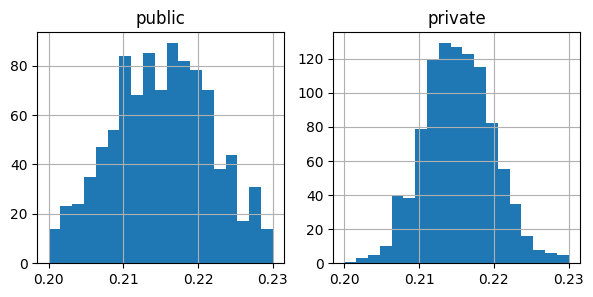

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
public_maes = []
private_maes = []
for _ in tqdm(range(1000)):
    random_idx = np.random.choice(range(len(oof_pred)), 500)
    public_maes.append(evaluation(train_df[targets].to_numpy()[random_idx], np.vstack(oof_pred)[random_idx]))

    random_idx = np.random.choice(range(len(oof_pred)), 1200)
    private_maes.append(evaluation(train_df[targets].to_numpy()[random_idx], np.vstack(oof_pred)[random_idx]))
axs[0].hist(public_maes, bins=np.linspace(0.20, 0.23, 20))
axs[0].grid()
axs[0].set_title("public")

axs[1].hist(private_maes, bins=np.linspace(0.20, 0.23, 20))
axs[1].grid()
axs[1].set_title("private")
plt.show()

# submit ファイル作成


In [ ]:
sub_col_names = [
    "x_0",
    "y_0",
    "z_0",
    "x_1",
    "y_1",
    "z_1",
    "x_2",
    "y_2",
    "z_2",
    "x_3",
    "y_3",
    "z_3",
    "x_4",
    "y_4",
    "z_4",
    "x_5",
    "y_5",
    "z_5",
]
sub_df = pl.DataFrame(np.vstack(test_pred), schema=sub_col_names)
sub_df = sub_df.with_columns(pl.Series("ID", test_df["ID"]))
sub_df.write_csv(os.path.join(CFG["output_dir"], "submission.csv"))

oof_df = pl.DataFrame(np.vstack(oof_pred), schema=sub_col_names)
oof_df = oof_df.with_columns(pl.Series("ID", train_df["ID"]))
oof_df.write_csv(os.path.join(CFG["output_dir"], "oof.csv"))

display(sub_df)
sub_df.drop("ID").write_csv(os.path.join(CFG["output_dir"], "submission_wo_ID.csv"))


x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,ID
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
1.4574,-0.079014,-0.032647,3.071899,-0.137671,-0.032889,4.524695,-0.181302,-0.050281,5.886816,-0.18872,-0.067151,7.15981,-0.319218,-0.046156,8.374101,-0.456937,-0.03019,"""012baccc145d400c896cb82065a93d…"
0.949536,0.40581,0.06588,1.904321,1.010808,0.076189,2.65619,1.756382,0.078897,3.272162,2.550617,0.086895,3.67508,3.482885,0.105149,4.162672,4.442993,0.113294,"""012baccc145d400c896cb82065a93d…"
1.625899,0.048176,0.020384,3.302721,0.076652,0.017574,4.838215,0.100614,0.005851,6.444947,0.076797,0.000201,7.859782,0.100696,0.000866,9.210332,0.132605,0.005004,"""012baccc145d400c896cb82065a93d…"
0.833911,0.120808,0.026599,1.693729,0.34621,0.025359,2.543839,0.566324,0.007868,3.151052,0.951239,-0.012863,3.802002,1.468163,-0.043749,4.416948,2.285877,-0.083978,"""012baccc145d400c896cb82065a93d…"
0.811287,-0.034538,-0.057028,1.446939,-0.050585,-0.071612,1.838146,-0.042985,-0.083291,1.982069,-0.032198,-0.090126,1.65992,-0.051194,-0.103227,1.144788,-0.050607,-0.112473,"""01d738e799d260a10f6324f78023b3…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6.545174,0.034973,0.018795,13.799386,0.090381,0.028749,21.052995,0.159874,0.034772,28.22664,0.25767,0.052277,35.57229,0.361826,0.057327,42.984538,0.540827,0.070431,"""ff4f00a76fbf4db0cb15579c7c6086…"
6.916087,-0.07006,-0.062843,14.798537,-0.105103,-0.06679,22.761678,-0.166527,-0.104159,30.799746,-0.204345,-0.194008,39.03662,-0.292833,-0.324984,47.11961,-0.444525,-0.519515,"""ff4f00a76fbf4db0cb15579c7c6086…"
7.393678,-0.060088,-0.039158,15.63527,-0.073403,-0.026429,23.770483,-0.111459,0.012047,31.815545,-0.15291,0.063158,39.772715,-0.167981,0.129529,47.725898,-0.189908,0.202011,"""ff4f00a76fbf4db0cb15579c7c6086…"
